Navigate to the minorminer project root

In [1]:
cd ~/Projects/minorminer/

/home/shannie/Projects/minorminer


In [2]:
from collections import Counter
from itertools import product
import math

import networkx as nx
import dwave_networkx as dnx
import matplotlib.pyplot as plt

import minorminer.layout as mml

# Functions for drawing pretty pictures

In [3]:
def draw_layouts(layouts, **kwargs):
    rows = math.ceil(len(layouts)/2)
    fig, axs = plt.subplots(rows, 2, figsize=(20,rows*10))
    if rows == 1:
        axs = [axs]
    for i, (name, layout) in enumerate(layouts.items()):
        axis = axs[int(i/2)][i%2]
        nx.draw_networkx(S, pos=layout, ax=axis, **kwargs)
        axis.title.set_text(f"{name}")
        
def draw_placement(placements, **kwargs):
    rows = math.ceil(len(placements)/2)
    fig, axs = plt.subplots(rows, 2, figsize=(20,rows*10))
    if rows == 1:
        axs = [axs]
    for i, (name, placement) in enumerate(placements.items()):
        axis = axs[int(i/2)][i%2]
        dnx.draw_chimera_embedding(
            C, 
            placement,
            S,
            ax=axis,
            **kwargs,
        )
        chain_lengths = Counter(len(C) for C in placement.values())
        overlaps = len([x for x, val in Counter(x for X in placement.values() for x in X).items() if val > 1])
        axis.title.set_text(f"{name} | {overlaps} overlaps | {dict(chain_lengths)} chains")

In [4]:
S = nx.random_regular_graph(3, 150)
C = dnx.chimera_graph(13)
P = dnx.pegasus_graph(13)

# Layouts
---
In general, a *layout* of $G$ is defined by the map 
$$f: V(G) \to \mathbb R^d$$

# p_norm
---
Let $f$ define a layout of $S$ into $\mathbb R^d$. Minimize the following energy function, $E$, by modifying $f$.
	    $$E = \sum_{u, v \in {G \choose 2}} \bigg(d_G \Big(u, v \Big) - \|f(u) - f(v)\|_p\bigg)^2$$

#### Parameters
- p: This changes the $p$-norm.

In [5]:
norms = list(range(1,4)) + [float("inf")]

In [6]:
p_norm = {f"{i}-norm": mml.p_norm(S, p=i) for i in norms}

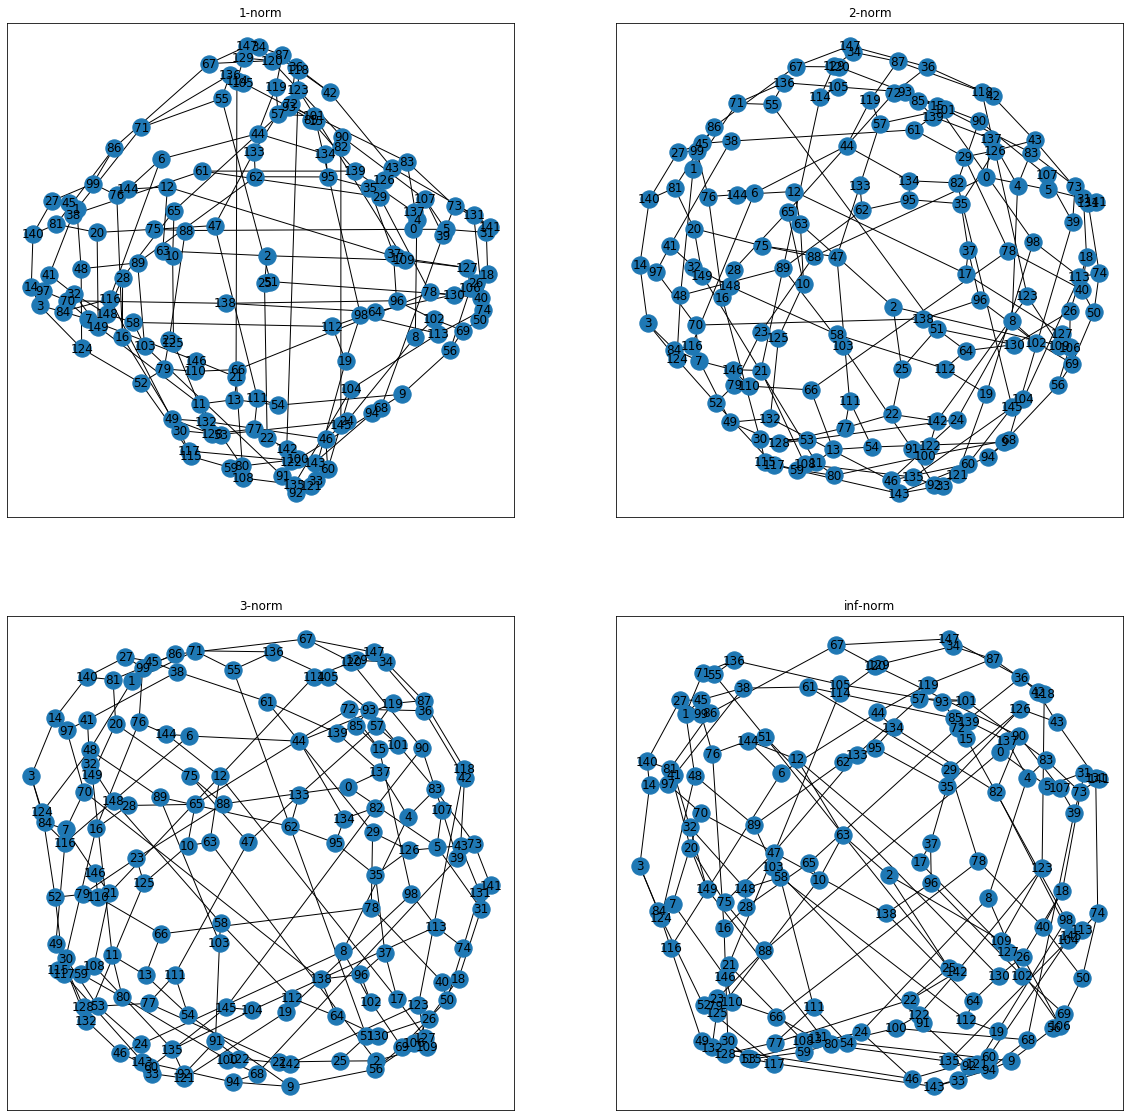

In [7]:
draw_layouts(p_norm)

# pca
---
First embeds a graph in an $m$-dimensional space using the graph distance. It then projects to a $d$-dimensional space using principal component analysis.

#### Parameters
- m: This changes the interium space to embed into.

In [8]:
M = [2, 50, 100, 150]

In [9]:
pca = {f"pca_{m}": mml.pca(S, m=m) for m in M}

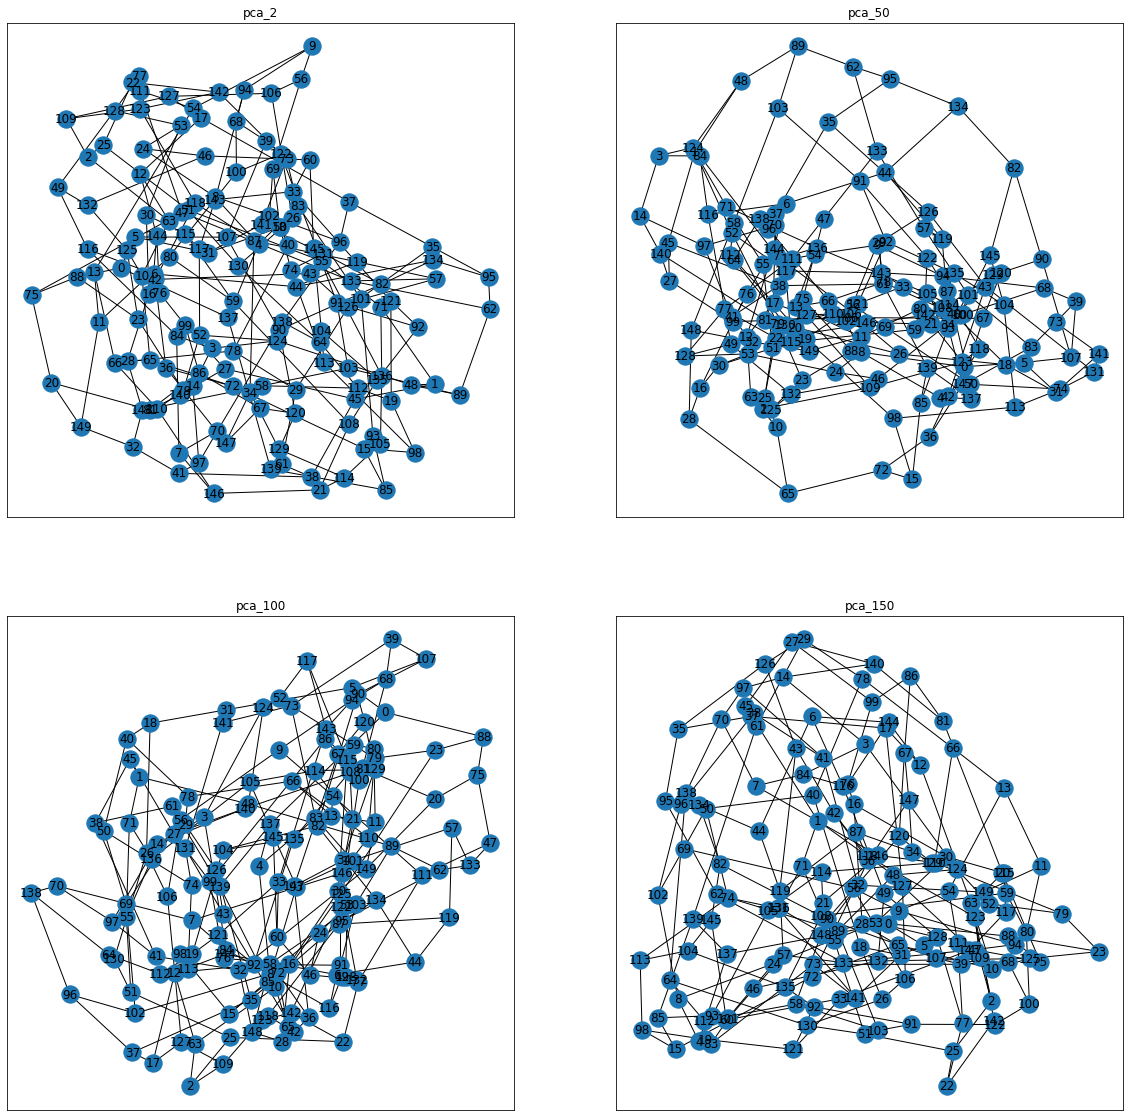

In [10]:
draw_layouts(pca)

# Any other layout
---
You can pass in any layout you would like as a dictionary `{vertices: points}` to the layout object.

In [11]:
layouts = {
    "spectral": mml.Layout(S, nx.spectral_layout(S)),
    "spring": mml.Layout(S, nx.spring_layout(S))
}

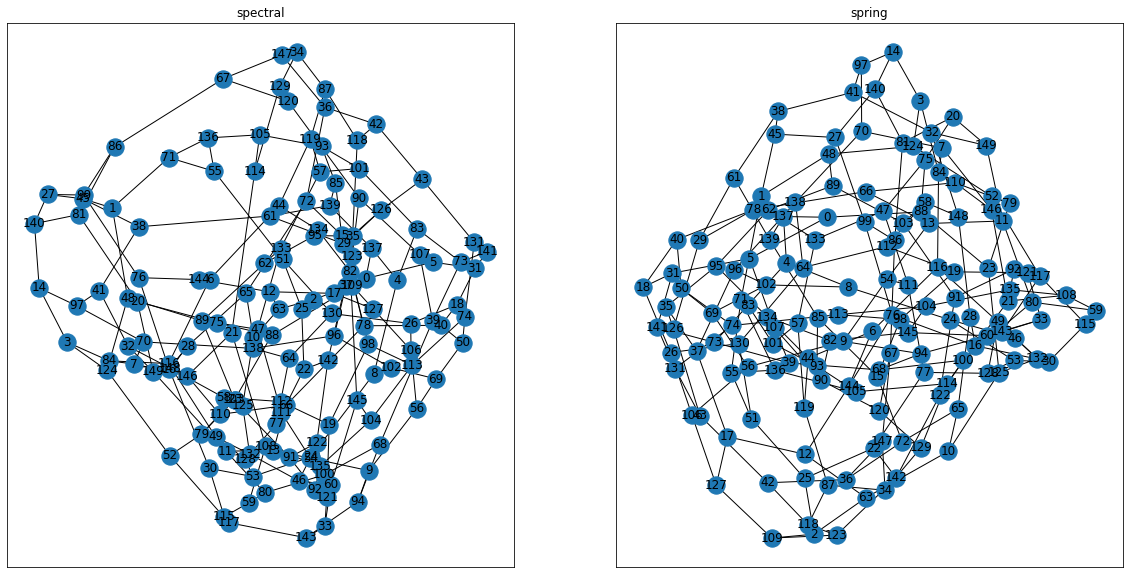

In [12]:
draw_layouts(layouts)

## Pick your favorite layout from above before continuing

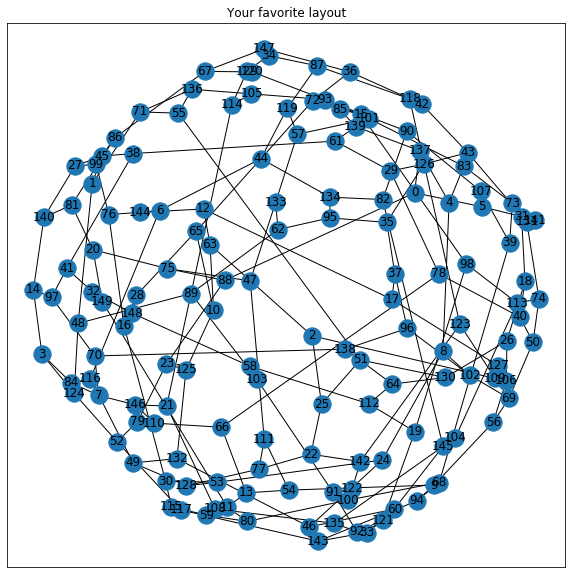

In [13]:
layout = p_norm["2-norm"]
fig, ax = plt.subplots(figsize=(10,10))
nx.draw_networkx(S, pos=layout)
ax.title.set_text("Your favorite layout")

# Placement
---
In general, we say that the map
$$\phi: V(S) \to 2^{V(T)}$$
defines a *placement* of $S$ in $T$ if $\phi(v)$ is connected for all $v \in V(S)$.

# closest
---
Let $f$ and $g$ define respective layouts of $S$ and $T$ into $\mathbb R^d$. With the default parameters, this algorithm maps each vertex $u$ in $S$, to some $v$ in $T$ that minimizes $\|f(u) - g(v)\|_2$.

#### Parameters
- num_neighbors: This is the number of points from $g(T)$ to check before assigning some $u$ in $S$ to $v$ in $T$. Increasing this decreases the overlap.
- subset_sizes: This allows the algorithm to consider larger sets than singletons from $V(T)$. A subset $X \subseteq V(T)$ is represented by the centroid of the points that comprise $X$. I.e. $g$ is extended so that $g: 2^{V(T)} \to \mathbb R^d$ and $g(X) = \texttt{centroid}(\{g(v)| v \in X\})$.
- fill_T: If True, $S$ is scaled so that it fills $T$.

In [15]:
subset_sizes = [(1,1), (1,2), (2,3)]
num_neighbors = [1, 20]

In [18]:
closest = {
    f"{neighbors} neighbors | {subsets} subsets | fill": mml.closest(
        layout, 
        C, 
        subset_size=subsets,
        num_neighbors=neighbors,
        fill_T=True
    ) for subsets, neighbors in product(subset_sizes, num_neighbors)
}
closest.update(
    {
        f"{neighbors} neighbors | {subsets} subsets": mml.closest(
            layout, 
            C, 
            subset_size=subsets,
            num_neighbors=neighbors
        ) for subsets, neighbors in product(subset_sizes, num_neighbors)
    }
)

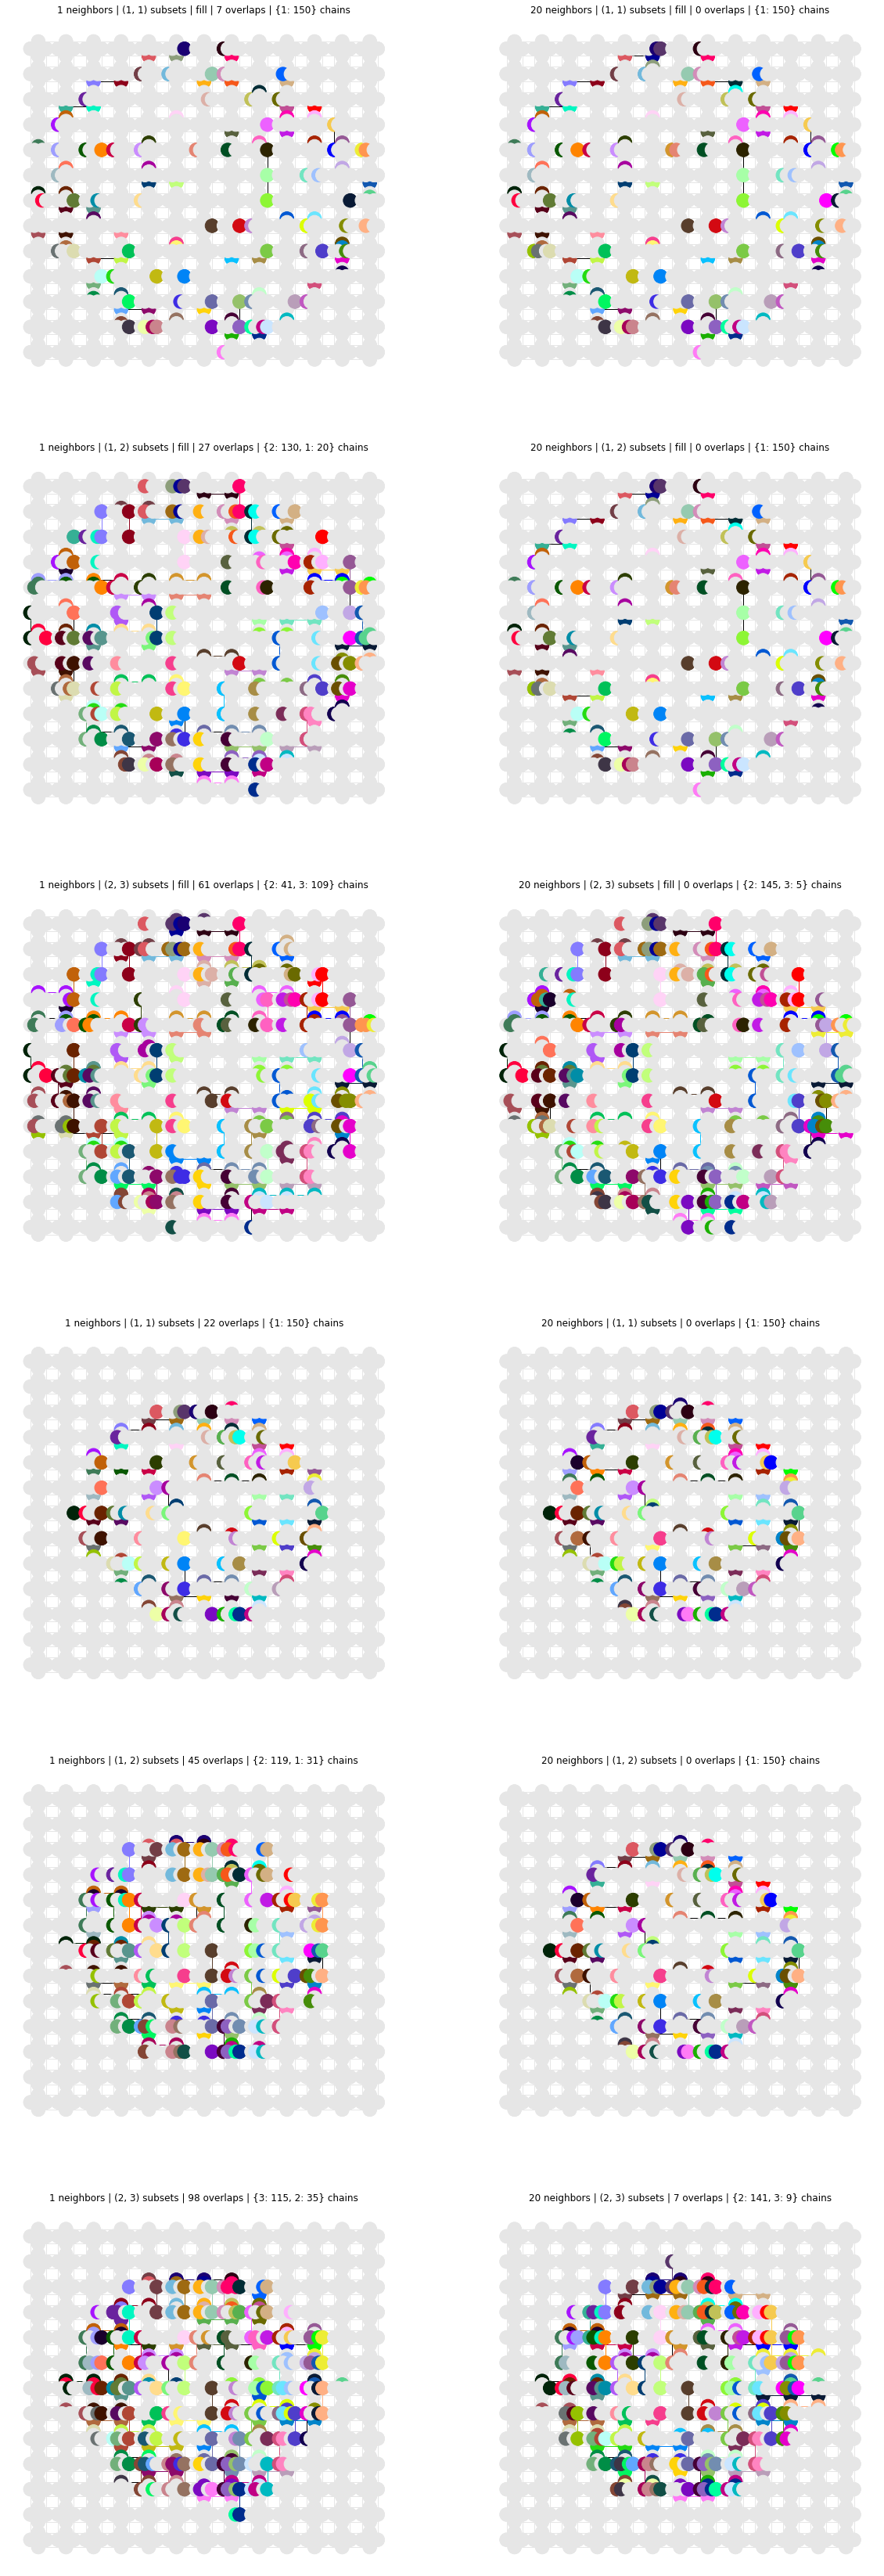

In [19]:
draw_placement(closest)

# Intersection
---
One can think of a Chimera or Pegasus as discretizations of the plane where vertical and horizontal columns and rows of qubits form grid lines. An intersection of a pair of these grid lines corresponds to a pair of qubits. We consider the union of these intersection points as a subset of the integer lattice $\mathbb Z^2$. This placement algorithm maps each $u$ in $S$ to the lattice point $(x, y)$ that that minimizes $\|f_S(u) - (x, y)\|_2$. 

#### Parameters
- fill_processor: This scales $f_S$ so that it fill the same space as the processor, or not.

In [42]:
intersection = {
    "fill": mml.intersection(layout, C),
    "dont_fill": mml.intersection(layout, C, fill_processor=False)
}

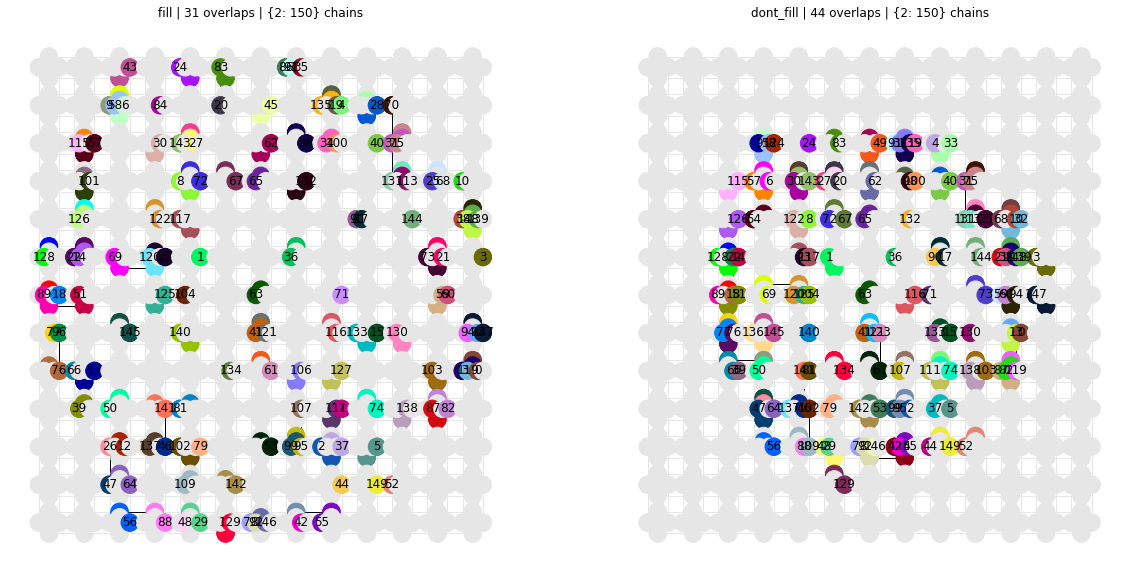

In [46]:
draw_placement(intersection, show_labels=True)